In [1]:
from tetris import Tetris
from random import randint, shuffle
import pickle

In [2]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc, colors, image
from IPython.display import HTML

Visualize game states:

In [3]:
def animate(states):
    'Creates animation from states list.'
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cmap = colors.ListedColormap(['black', 'red', 'blue'])
    norm = colors.Normalize(0, 2)
    ax.axis('off')
    images = []
    for state in states:
        well, score, is_game_over = state
        sc = ax.annotate(f"score: {score}",(1,19), color='white')
        image = ax.imshow(well, cmap=cmap, norm=norm)
        if is_game_over:
            go = ax.annotate("GAME OVER", (2, 10), color='white')
            images = images + ([[image, go] * 3, [image] * 3] * 10)
            break
        images.append([image, sc])

    return animation.ArtistAnimation(fig, images, interval=50, blit=True,
                                    repeat_delay=1000)


In [4]:
def play(player, max_steps = 10000):
    'Plays tetris with player and returns list of states.'
    tetris = Tetris()
    states = [tetris.step(0)]
    is_game_over = False
    for _ in range(max_steps):
        state = tetris.step(player(states[-1][0]))
        states.append(state)
        _,_,is_game_over = state
        if is_game_over:
            break
    return states

In [5]:
def random_player(well):
    'Returns random action.'
    return randint(0, 4)

In [6]:
states = play(random_player)

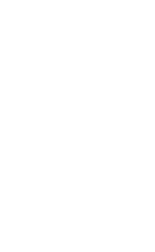

In [7]:
ani = animate(states)

In [8]:
HTML(ani.to_html5_video())

Start very deep learning:

In [9]:
import numpy as np
import os
import random
import tensorflow as tf

/home/max/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [10]:
def gather_columns(params, indices):
    # prepare row indices
    row_indices = tf.range(tf.shape(indices)[0])
    # zip row indices with column indices
    full_indices = tf.stack([row_indices, indices], axis=1)
    # retrieve values by indices
    return tf.gather_nd(params, full_indices)

Q-function:

In [11]:
def build_q_function(resolution, n_actions):
    with tf.variable_scope("Q_function"):
        well_pl = tf.placeholder(shape=[None] + resolution + [2], dtype=tf.float32, name="well")
        reward_pl = tf.placeholder(shape=[None], dtype=tf.float32, name="reward")
        action_pl = tf.placeholder(shape=[None], dtype=tf.int32, name="action")
        
        conv_1 = tf.layers.conv2d(well_pl, 32, 4, strides=(1,1), activation=tf.nn.relu, name="conv_1", padding="VALID")
        pool_1 = tf.nn.max_pool(conv_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID", name="pool_1")
        conv_2 = tf.layers.conv2d(pool_1, 32, 2, strides=(1,1), activation=tf.nn.relu, name="conv_2")
        pool_2 = tf.nn.max_pool(conv_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID", name="pool_2")
        flatten = tf.contrib.layers.flatten(pool_2)
        print(flatten.shape)
        dense1 = tf.layers.dense(flatten, 192, activation=tf.nn.relu, name="dense1")
        #dense2 = tf.layers.dense(dense1, 3200, activation=tf.nn.relu, name="dense2")
        output = tf.layers.dense(dense1, n_actions, name="output")
        q_value = gather_columns(output, action_pl)
        #mask = tf.one_hot(action_pl, n_actions)
        #masked = tf.multiply(output, mask)
        #q_value = tf.reduce_sum(masked, axis=1)
        loss = tf.reduce_mean(tf.squared_difference(reward_pl, q_value))
        train_op = tf.train.AdamOptimizer().minimize(loss, global_step=tf.train.get_or_create_global_step())
        
        summary = tf.summary.merge(
                [tf.summary.scalar("loss", loss),
                tf.summary.histogram("q_value", q_value)])
        
        return (well_pl, reward_pl, action_pl), (output, loss, train_op, summary)        

Predict function:

In [12]:
def build_estimator(sess, well_pl, output):
    
    def estimate(sess, well_pl, output, wells):
        feed_dict = { 
            well_pl: wells
        }
        return sess.run([output], feed_dict)
    
    def estimator(wells):
        return estimate(sess, well_pl, output, wells)
    
    return estimator;

Train function:

In [13]:
def build_trainer(sess, well_pl, action_pl, reward_pl, loss, train_op, summary, writer):
    
    def train(sess, well_pl, reward_pl, action_pl, loss, train_op, summary, wells, actions, rewards):
        feed_dict = { 
            well_pl: wells,
            reward_pl: rewards,
            action_pl: actions
        }
        
        return sess.run([loss, train_op, summary, tf.train.get_or_create_global_step()], feed_dict)
    
    def trainer(wells, actions, rewards):
        loss_val, _, summary_val, step = train(sess, well_pl, reward_pl, action_pl, 
                        loss, train_op, summary, wells, actions, rewards)
        writer.add_summary(summary_val, step)
        return loss_val
    
    return trainer;

Split well to channel with figure and channel with trash:

In [14]:
def preprocess(well):
    return np.array([[[v == 1, v == 2] for v in row] for row in well], dtype=float)

Initialize model:

In [15]:
tf.reset_default_graph()
(well_pl, reward_pl, action_pl), (output, loss, train_op, summary) = build_q_function([20, 10], 5)

(?, 96)


In [16]:
sess = tf.InteractiveSession()

In [17]:
sess.run(tf.global_variables_initializer())

In [18]:
devices = sess.list_devices()
for d in devices:
    print(d.name)

/job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:GPU:0


In [19]:
estimate = build_estimator(sess, well_pl, output)
dirpath = 'tfboard'
if tf.gfile.Exists(dirpath):
   tf.gfile.DeleteRecursively(dirpath) 
writer = tf.summary.FileWriter(dirpath, sess.graph)
train = build_trainer(sess, well_pl, action_pl, reward_pl, loss, train_op, summary, writer)

In [ ]:
# train_op = tf.train.AdamOptimizer().minimize(loss, global_step=tf.train.get_or_create_global_step())
# train = build_trainer(sess, well_pl, action_pl, reward_pl, loss, train_op, summary, writer)

Reward calculation helpers:

In [ ]:
def calc_well_stat(x):
    'Returns tuple of filled cells count and partialy filled rows count'
    non_empty_rows = 0
    filled_cells = 0
    for i in range(len(x)):
        s = sum([f[0] for f in x[i]])
        if s != 0:
            non_empty_rows += 1
            filled_cells += s
    return (filled_cells, non_empty_rows)

def is_figure_touch(x):
    for i in range(len(x)):
        for j in range(len(x[i])):
            if x[i][j][1] > 0:
                return False
    return True

def calc_lines_entropy(x):
    n_tears = 0
    n_lines = 0
    for i in range(len(x)):
        prev = x[i][0][0]
        n_line_tears = 0
        for j in range(1, len(x[i])):
            if prev != x[i][j][0]:
                n_line_tears += 1
                prev = x[i][j][0]
        if n_line_tears > 0:
            n_lines += 1
        n_tears += n_line_tears
    return n_lines, n_tears

Helpers test:

In [ ]:
well = [[0] * 10] * 10 + [[1] * 10] * 10
x = preprocess(well)
assert calc_well_stat(x) == (100, 10)

assert is_figure_touch(x)

# Add figure
well[0] = [0] * 3 + [2] * 4 + [0] * 3
assert not is_figure_touch(preprocess(well))

We generate randomly filled rows to increase probability to drop line with random action: 

In [20]:
def generate_well(max_filled_rows = 17, max_tears = 5):
    n_rows = randint(0, max_filled_rows)
    well = [[0] * 10 for _ in range(20 - n_rows)]
    for _ in range(n_rows):
        n_tears = randint(1, max_tears)
        tear_ind = np.random.choice(10, n_tears, replace=False)
        row = [1] * 10
        for i in tear_ind:
            row[i] = 0
        well.append(row)
    return well

In [ ]:
def generate_action_sequence(drop_prob=0.5):
    # move left
    actions = [randint(1, 2)] * randint(0, 4)
    # move right
    actions += [3] * randint(0, 3)
    # drop or leave
    if np.random.rand() < drop_prob:
        actions.append(4)
    else:
        actions += [0] * 20
    return actions

In [ ]:
def generate_sample_sequence():
    while True:
        well = generate_well(10)
        t = Tetris(well = well)
        actions = generate_action_sequence()
        samples = []
        prev_state = preprocess(well)
        for action in actions:
            well, score, is_game_over = t.step(action)
            state = preprocess(well)
            sample = prev_state, action, score / 100, state, is_game_over
            samples.append(sample)
            prev_state = state
            if score > 0:
                break
            if is_game_over:
                break 
        if len(samples) > 0:
            yield samples

In [21]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.__capacity = capacity
        self.__buffer = []
        self.__index = 0
        
    def add(self, entry):
        if len(self.__buffer) < self.__capacity:
            self.__buffer.append(entry)
        else:
            self.__buffer[self.__index] = entry
            self.__index += 1
            if self.__index >= self.__capacity:
                self.__index = 0
                
    def prepare_batch(self, batch_size, gamma):
        if batch_size < 1:
            return [], [], []
        indices = np.random.choice(len(self.__buffer), min(batch_size, len(self.__buffer)), replace=False)
        X = [self.__buffer[i][0] for i in indices]
        actions = [self.__buffer[i][1] for i in indices]
        rewards = np.array([self.__buffer[i][2] for i in indices])
        X_next = [self.__buffer[i][3] for i in indices]
        terminal_flags = np.array([not self.__buffer[i][4] for i in indices], dtype = float)
        q_values = np.squeeze(np.max(estimate(X_next), axis=-1))
        y_train = rewards + q_values * terminal_flags * gamma
        return X, actions, y_train   
    
    def save(self, file_name):
        with open(file_name, 'wb') as file:
            pickle.dump(self.__buffer, file)
            
    def load(self, file_name):
        with open(file_name, 'rb') as file:
            self.__buffer = pickle.load(file)
        self.__index = 0
        
    def __len__(self):
         return len(self.__buffer)

In [ ]:
def fill_reply_buffers(positvie_buffer, other_buffer, samples_n = 10000):
    positive_added_n = 0
    for seq in generate_sample_sequence():
        if seq[-1][2] > 0:
            positvie_buffer.add(seq[-1])
            positive_added_n += 1
            if (positive_added_n >= samples_n):
                break
            print(f"Positive added: {positive_added_n}", end='\r')
        else:
            for sample in seq: other_buffer.add(sample)

In [22]:
positive_buffer = ReplayBuffer(100000)
other_buffer = ReplayBuffer(100000)

In [ ]:
%%time
fill_reply_buffers(positive_buffer, other_buffer, samples_n=10000)

In [23]:
#positive_buffer.load("pb.bin")
#other_buffer.load("ob.bin")

Learning session:
    eps - random action probability
    gamma - discount factor

In [ ]:
def learn(positive_buffer, 
          other_buffer,
          estimate, 
          train, 
          eps=0.9, 
          gamma=0.99, 
          replay_capacity=100000, 
          batch_size=32, 
          episode_n=100, 
          steps_n=1000):
        
    max_score = 0
    for i in range(episode_n):
        tetris = Tetris(well=generate_well(15))
        well, score, _ = tetris.step(0)
        x = preprocess(well)
        actions = []
        for j in range(steps_n):
            if len(actions) == 0:
                if np.random.rand() < eps:
                    actions = [randint(0, 4)] # * randint(1, 4)
                else:
                    actions = [np.argmax(estimate([x]))]
            a = actions.pop()
            well, new_score, is_game_over = tetris.step(a)
            new_x = preprocess(well)
            r = float(new_score - score)
            score = new_score
            replay_entry = (x, a, r, new_x, is_game_over)
            x = new_x
            if r > 0:
                positive_buffer.add(replay_entry)
            else:
                other_buffer.add(replay_entry)
            n_positive_samples = min(len(positive_buffer), batch_size // 4)
            batch_pos = positive_buffer.prepare_batch(n_positive_samples , gamma) 
            batch_other = other_buffer.prepare_batch(batch_size - n_positive_samples , gamma)
            batch_zipped = list(zip(*batch_pos)) + list(zip(*batch_other))
            shuffle(batch_zipped)
            state_batch, actions_batch, rewards_batch = list(zip(*batch_zipped))
            loss = train(state_batch, actions_batch, rewards_batch)
            print(f"Episode: {i}, step: {j}, reward: {r:.2}, score: {score}, max score: {max_score}, loss: {loss:.3}     ", end='\r')
            if is_game_over:
                break
        max_score = max(max_score, score)
    return 

In [ ]:
learn(positive_buffer, other_buffer, estimate, train, eps=0.5, episode_n=100, batch_size=32)

In [26]:
def neuro_player(well):
    'Returns model predicted action.'
    return np.argmax(estimate([preprocess(well)]))

Start session:

In [53]:
for eps in np.linspace(0.2, 0.0, 11):
    learn(positive_buffer, other_buffer, estimate, train, eps=eps, episode_n=1000, batch_size=256)
    states = play(neuro_player)
    with open('replay.bin', 'wb') as file:
        pickle.dump(states, file)
    print(f"Eps: {eps:.2}, steps: {len(states)}, score: {states[-1][1]}                                              ")

Eps: 0.2, steps: 137, score: 0                                              7          
Eps: 0.18, steps: 121, score: 0                                                        
Eps: 0.16, steps: 109, score: 0                                              8         


KeyboardInterrupt: 

Check how model plays:

In [61]:
max_score = 0
for _ in range(1000):
    states = play(neuro_player)
    if states[-1][1] > max_score:
        max_score = states[-1][1]
        best_game = states

In [62]:
states = best_game

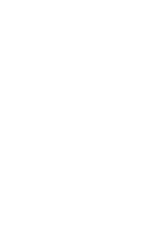

In [63]:
ani = animate(states)

In [64]:
HTML(ani.to_html5_video())

In [65]:
ani.save("tetris.mp4")